In [20]:
import numpy as np
from sklearn import datasets
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data')
# df_wine.columns = ['Class label', 
#                    'Alcohol', 
#                    'Malic acid', 
#                    'Ash',
#                    'Alcanlinity of Ash', 
#                    'Magnesium',
#                    'Total phenols',
#                    'Flavanoids',
#                    'Nonflavanoid phenols',
#                    'Proanthocyanins',
#                    'Color intensity', 
#                    'Hue',
#                    '0D280/0D315 of diluted wines',
#                    'proline']
df_wine


,1,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
173,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
174,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
175,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [21]:
from sklearn.model_selection import train_test_split

# X는 두번째부터 마지막 모든 열(13개)
# y는 데이터프레임에서 가장 첫번째 열(1개)
X, y = df_wine.iloc[:, 1:].values , df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size= 0.3, # test는 전체의 30%
                                                    random_state=0, 
                                                    stratify=y)

In [22]:
from sklearn.preprocessing import StandardScaler
# 표준화
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

LDA 수행에 필요한단계.
LDA목표, 클래쓰 내의 분산을 최소하하고, 클래쓰 끼리의 분산은 최대화한다!

1. 데이터셋을 표준화 전처리한다.
2. 각 클래쓰에 대해 d차원 평균벡터를 계산한다.
3. 클래스 간의 산포행렬과 클래쓰 내 산포행렬을 구성한다.
4. 클래스 내의 산포행렬의 역행렬 x 클래스 간의 산포행렬 의 고유벡터와 고윳값을 계산한다.
5. 고윳값 순서대로 내림차순해서 변환행렬의 차원을 결정한다. (w 행렬 결정)
6. 변환행렬을 데이터셋에 .dot(w)적용해서 변환한다.

In [23]:
np.set_printoptions(precision=4)# 넘파이 배열이 출력할때 소수점4자리 까지만 표시 옵션,
mean_vecs = []

# wine데이터셋에서 3개의 특성에 대해 평균 벡터 만들기
for label in range(1, 4):
    mean_vecs.append(np.mean(
        X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))



MV 1: [ 0.8807 -0.3428  0.2687 -0.8193  0.4718  0.8881  0.9597 -0.6325  0.4794
  0.2394  0.5838  0.6963  1.2367]

MV 2: [-0.8811 -0.2894 -0.3636  0.3329 -0.398  -0.0317  0.0938 -0.0514  0.137
 -0.8377  0.3394  0.3511 -0.7462]

MV 3: [ 0.2336  0.8204  0.208   0.4841  0.0186 -0.9991 -1.2643  0.8182 -0.7615
  0.9256 -1.1759 -1.3252 -0.3796]



In [24]:
d = d = X_train_std.shape[1] # 특성의 개수
S_W = np.zeros((d, d))

for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d, d)) # 각 클래쓰에 대한 산포행렬을 0으로 초기화한다.
    for row in X_train_std[y_train == label]: # label에 해당하는 X_train_std의 모든 샘플에 대해 반복한다

        # 각 샘플과 클래스의 평균 벡터 간의 차이를 벡터형태로 계산한다.
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)   # row, mv는 현재 1xd 벡터임으로 dx1벡터로 변환한다.
        class_scatter += (row - mv).dot((row-mv).T)     # 각 샘플과 클래스의 평균 벡터 간의 차이 계산
    S_W += class_scatter    #총 클래스 내 산포 행렬 업데이트

print('클래쓰 내의 산포행렬: %sx%s' %(S_W.shape[0], S_W.shape[1]))

클래쓰 내의 산포행렬: 13x13


In [25]:
d = d = X_train_std.shape[1] # 특성의 개수
S_W = np.zeros((d, d))

for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T) # 각 클래쓰에 대한 산포행렬을 0으로 초기화한다.
    S_W += class_scatter    #총 클래스 내 산포 행렬 업데이트
print('클래쓰 조정된 클래스 내의 산포행렬: %sx%s' %(S_W.shape[0], S_W.shape[1]))

mean_overall = np.mean(X_test_std, axis=0)# 데이터셋의 모든 샘플에 대한 평균을 계산한다. aixs=0을 통해서 열 단위 평균을 계산한다.
mean_overall = mean_overall.reshape(d, 1) # 행벡터를 열벡터로 만들기

d = d = X_train_std.shape[1]# 특성의 개수
S_B = np.zeros((d, d))      # 클래쓰 끼리의 산포행렬을 d x d 크기의 값이 0인 튜플로 초기화한다 
for i, mean_vec in enumerate(mean_vecs): # enumerate는 인덱스와, 이터레이터의 값을 동시에 제공
    n = X_train[y_train == i + 1, :].shape[0]   #마친 mean_vecs는 3개의 벡터라서 이렇게 한거같다. y_train값과 mean_vecs의 인덱스 값은 실제론 무관하다.
    mean_vec = mean_vec.reshape(d, 1)   # 열 벡터로 만들기
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('클래쓰 간의 산포행렬: %sx%s' %(S_B.shape[0], S_B.shape[1]))

클래쓰 조정된 클래스 내의 산포행렬: 13x13
클래쓰 간의 산포행렬: 13x13


In [28]:
# 고유벡터와 고윳값 쌍을 계산.
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
# eigen_vals, eigen_vecs 튜플 쌍 만들기
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# eigen_val 값 기준으로 내림차순 정렬하기
eigen_pairs = sorted(eigen_pairs, key=lambda k : k[0], reverse=True)
print('내림차순의 고윳값\n')

for eigein_val in eigen_pairs:
    print(eigein_val[0])



내림차순의 고윳값

367.6327707926619
163.5777142799625
3.39196580780033e-14
3.39196580780033e-14
2.842170943040401e-14
2.8020664631362964e-14
2.8020664631362964e-14
1.0506645130553528e-14
6.526015968985906e-15
6.526015968985906e-15
3.969132076927008e-15
3.969132076927008e-15
1.0660427161277914e-16


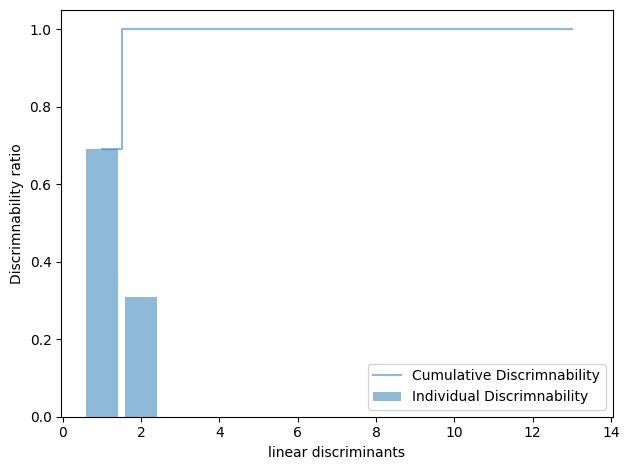

In [29]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals.real)
discr = [(i / tot ) for i in sorted(eigen_vals.real, reverse=True)]
sum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha = 0.5, align='center', label = 'Individual Discrimnability')    # 분산의 크기에 대한 막대그래프 
plt.step(range(1, 14), sum_discr, alpha = 0.5, where='mid', label = 'Cumulative Discrimnability')  # 누적 분포에 표현 계단그래프
plt.ylabel('Discrimnability ratio')
plt.xlabel('linear discriminants')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()


3개의 추출된 특성중, 2개의 선형 판별 벡터가 Wine에 있는 정보를 거의 100퍼센트 잡아낸다.
즉, 2개의 판별 고유벡터를 선택해서 변환행렬W를 생성할수있다.

In [30]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
print('행렬 w:\n', w)

행렬 w:
 [[-0.1178 -0.3454]
 [ 0.0538 -0.1982]
 [ 0.0132 -0.2757]
 [ 0.1464  0.2765]
 [-0.0114 -0.0372]
 [ 0.1857  0.0709]
 [-0.7478  0.2596]
 [-0.0529  0.0567]
 [ 0.0094  0.1547]
 [ 0.2737 -0.2711]
 [-0.0899  0.24  ]
 [-0.3504  0.0053]
 [-0.399  -0.676 ]]


이젠 위에서 구한 변환 행렬을 이용해서 샘플을 실제로 투영시켜 볼것이다.

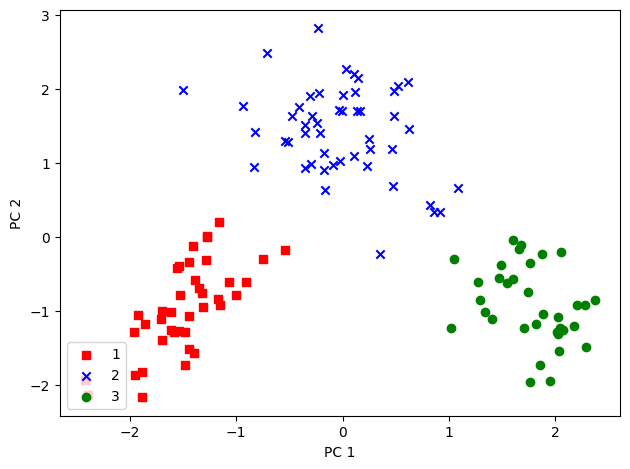

In [31]:
X_train_lda = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1],
                c = c,
                label = l,
                marker= m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

위의 과정을 사이킷런 모델의 LDA를 이용해서 동일한 작업을 다시 수행해볼것이다.

/home/viplab/바탕화면/machine_learning_study/머신러닝교과서/데이터 전처리/특성추출/PDR.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  label=cl, edgecolor='black')


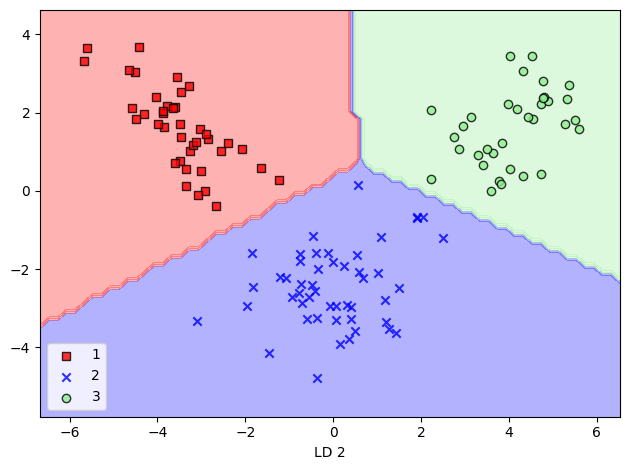

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2) # 추출한 특성의 개수를 2개로 명시
X_train_lda = lda.fit_transform(X_train_std, y_train) # 행렬 변환 실행 + 지도학습임으로 y_train이 제공된다.

# 로지스틱 회귀 분류를 이용해서 실제로 데이터 분류해보기
import PDR
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# PCA, 로지스틱회기 분류기 초기화
lr = LogisticRegression(random_state=1)
lr.fit(X_train_lda, y_train)

# 분류된 결과를 시각적으로 표시
PDR.plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.xlabel('LD 2')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show()